### Travel mode choice - Logistic regression

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn import preprocessing  ## for standardization 
from sklearn.metrics import confusion_matrix
import pystan
import pystan_utils

We will consider a real world problem with discrete target variables:

$y$: travel model choice. 

The goal is to model the travel mode choices (plane, train, bus or car) based on trip characteristics/features ($X$) such as the terminal waiting time, cost, travel time, etc. We shall start by using a logistic regression model for this.

In [2]:
df = pd.read_csv("mode_choice_data.csv")
print(df.shape)
df.head()

(394, 19)


,individual,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car,mode_chosen
0,70,30,4,10,61,80,73,44,24,350,77,53,19,395,79,4,314,52,1
1,8,15,4,64,48,154,71,55,25,360,80,53,14,462,84,4,351,57,2
2,62,35,2,64,58,74,69,30,21,295,66,53,24,389,83,7,315,55,2
3,61,40,3,45,75,75,96,44,33,418,96,53,28,463,98,5,291,49,1
4,27,70,1,20,106,190,127,34,72,659,143,35,33,653,104,44,592,108,1


Variable name definitions:

    mode_chosen =
        1 - air
        2 - train
        3 - bus
        4 - car
    ttme = terminal waiting time for plane, train and bus (minutes); 0 for car.
    invc = in vehicle cost for all stages (dollars).
    invt = travel time (in-vehicle time) for all stages (minutes).
    gc = generalized cost measure:invc+(invt*value of travel time savings)(dollars).
    hinc = household income ($1000s).
    psize = traveling group size in mode chosen (number).

Some basic data statistics:

In [3]:
df.describe()

,individual,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car,mode_chosen
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,39.032995,34.228426,1.761421,61.215736,83.350254,132.005076,100.510152,35.685279,49.832487,597.847716,127.101523,42.000000,33.073604,624.718274,114.065990,21.101523,565.667513,94.170051,2.675127
std,22.816704,19.276048,1.030790,15.780674,26.625461,45.484891,29.081987,12.712417,26.727488,245.826336,55.855820,11.962409,12.787644,233.524090,43.468285,15.164236,263.027420,44.398771,1.213176
min,1.000000,2.000000,1.000000,5.000000,44.000000,63.000000,56.000000,1.000000,11.000000,255.000000,42.000000,5.000000,12.000000,227.000000,45.000000,2.000000,180.000000,32.000000,1.000000
25%,19.250000,18.000000,1.000000,64.000000,59.250000,95.750000,72.000000,34.000000,30.000000,357.000000,74.000000,35.000000,25.000000,406.000000,73.000000,10.000000,315.000000,52.000000,2.000000
50%,39.000000,35.000000,1.000000,64.000000,81.000000,125.000000,96.000000,34.000000,36.000000,602.000000,119.000000,35.000000,31.000000,599.000000,105.000000,16.000000,577.000000,96.000000,3.000000
75%,57.750000,45.000000,2.000000,69.000000,105.000000,158.000000,125.000000,44.000000,72.000000,873.000000,177.000000,53.000000,44.000000,870.000000,145.000000,31.500000,858.000000,135.000000,4.000000
max,80.000000,72.000000,6.000000,90.000000,180.000000,333.000000,197.000000,99.000000,111.000000,1104.000000,269.000000,60.000000,70.000000,1110.000000,222.000000,86.000000,1440.000000,228.000000,4.000000


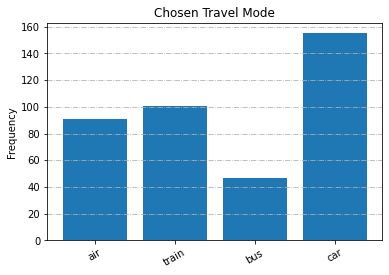

In [4]:
no_mode = df.mode_chosen.value_counts().sort_index().values.tolist()
label = ["air","train","bus","car"]
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_mode)
    #plt.xlabel('Travel mode')
    plt.ylabel('Frequency')
    plt.xticks(index, label, rotation=30)
    plt.grid(linestyle="-.",axis="y")
    plt.title('Chosen Travel Mode')
    plt.show()

plot_bar_x()

Let's now preprocess the data by:
- Separating the inputs ($X$) from the target ($y$)
- Standardizing the input variables in order to have zero mean and unit standard deviation
- Split data into train and test sets

In [5]:
# Separate between features/inputs (X) and target/output variables (y)
X = df.drop(["individual","mode_chosen"],axis=1)

In [6]:
# Get column names first
names = X.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=names)
scaled_X.head()

,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car
0,-0.219641,2.174473,-3.249598,-0.840499,-1.144802,-0.947154,0.654895,-0.967743,-1.009505,-0.898120,0.920716,-1.101962,-0.984953,-0.807729,-1.129188,-0.958027,-0.951010
1,-0.998798,2.174473,0.176659,-1.329374,0.484180,-1.016013,1.521291,-0.930280,-0.968774,-0.844342,0.920716,-1.493462,-0.697680,-0.692556,-1.129188,-0.817179,-0.838251
2,0.040078,0.231747,0.176659,-0.953316,-1.276882,-1.084871,-0.447791,-1.080129,-1.233524,-1.095306,0.920716,-0.710462,-1.010679,-0.715590,-0.931102,-0.954221,-0.883354
3,0.299798,1.203110,-1.028876,-0.314018,-1.254868,-0.155281,0.654895,-0.630583,-0.732535,-0.557526,0.920716,-0.397263,-0.693393,-0.370073,-1.063159,-1.045582,-1.018665
4,1.858112,-0.739617,-2.615106,0.851762,1.276658,0.912026,-0.132738,0.830445,0.249078,0.284996,-0.585910,-0.005763,0.121262,-0.231865,1.511952,0.100240,0.311890


In [7]:
# X and y as matrix
X = scaled_X.values
y = df["mode_chosen"].astype("int").values

In [8]:
# Split data into train and test sets
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("No. of train data: %d" % len(y_train))
print("No. of test data: %d" % len(y_test))

No. of train data: 260
No. of test data: 134


### Plate notation

![title](PGM_CLS.png)

### Stan model : Multinomial regression model

Ok, time to do it in STAN!

Since we don't have a column in the inputs (X) that is always equal to 1, we need to incorporate the bias term in our model explicitly. Hence, we shall include an extra set of bias parameters $\boldsymbol\alpha = \{\alpha_1,\dots,\alpha_C\}$ in the model. The likelihood is then of the form:

$y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\boldsymbol\alpha + \textbf{B} \textbf{x}_n^T))$


where $\textbf{B} = (\boldsymbol\beta_1,\dots,\boldsymbol\beta_C)^T$

STAN expects the targets $y_n$ as integers in {1,2,3,4}!



In [9]:
STAN_multi_reg = """
data {
    int<lower=1> N;             // number of data items
    int<lower=1> D;             // number of features
    int<lower=1> C;             // class count
    int y[N];
    matrix[N,D] X;
}
parameters {
    vector[C] alpha;
    matrix[C,D] beta;
}
model {
    alpha ~ normal(0,1);
    for (c in 1:C)
        beta[c] ~ normal(0,1);  // assign priors at vectors once instead of two for loops

    for (n in 1:N)
        y[n] ~ categorical(softmax(alpha + beta * X[n]'));
        // equal to y[n] ~ categorical_logit(alpha + beta * X[n]');
}
"""

## compile model
sm = pystan.StanModel(model_code = STAN_multi_reg)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_74110ff61fc925af8e77dcb1a2d1f837 NOW.


In [10]:
# prepare data for Stan model
N, D = X_train.shape
C = int(len(np.unique(y_train)))
print("N=%d, D=%d, C=%d" % (N,D,C))
data = {'N': N, 'D': D, 'C': C, 'X': X_train, 'y': y_train}

N=260, D=17, C=4


### MCMC method

In [14]:
%%time
# run inference
iterations = 2000
no_chains = 4
fit = sm.sampling(data=data, algorithm="NUTS", seed=0, chains=no_chains, iter= iterations, control={'max_treedepth': 50})

# show results
print(fit)

Inference for Stan model: anon_model_74110ff61fc925af8e77dcb1a2d1f837.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]     0.12  9.2e-3   0.55  -0.97   -0.26   0.12    0.5   1.18   3598    1.0
alpha[2]     0.07  9.6e-3   0.55  -1.06    -0.3   0.07   0.45   1.14   3324    1.0
alpha[3]    -1.36    0.01    0.6  -2.57   -1.76  -1.36  -0.94  -0.24   3336    1.0
alpha[4]     1.16  9.1e-3   0.54    0.1    0.79   1.15   1.52   2.22   3455    1.0
beta[1,1]    0.09  8.9e-3   0.53  -0.93   -0.27   0.09   0.46   1.11   3534    1.0
beta[2,1]   -0.34  9.1e-3   0.54  -1.41   -0.69  -0.33   0.03   0.73   3577    1.0
beta[3,1]    0.05  9.1e-3   0.57  -1.08   -0.33   0.06   0.43   1.16   3887    1.0
beta[4,1]    0.15  8.8e-3   0.52  -0.85   -0.21   0.15   0.51   1.17   3471    1.0
beta[1,2]   -0.46  9.2e-3   0.56  -1.58   -0.84  -0.45  -0.08   

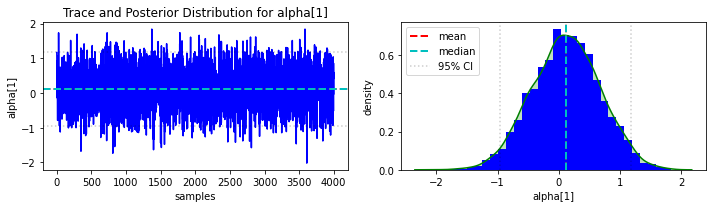

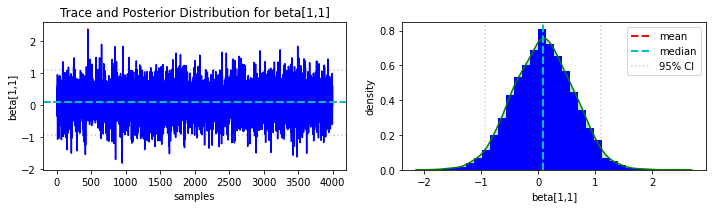

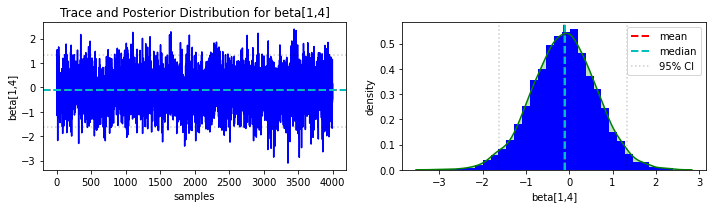

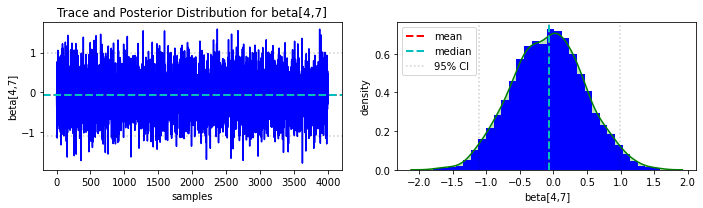

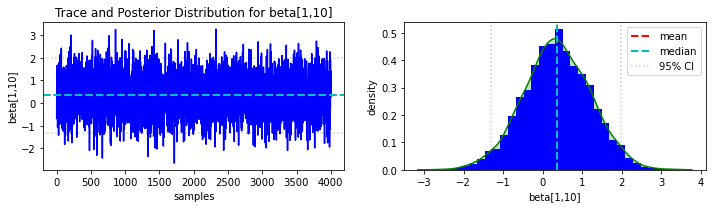

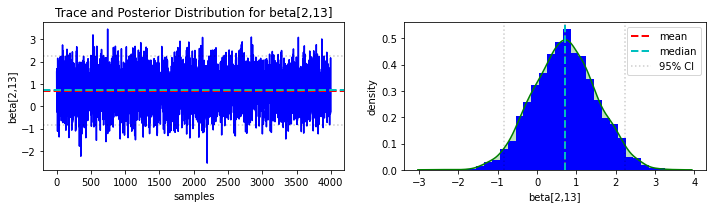

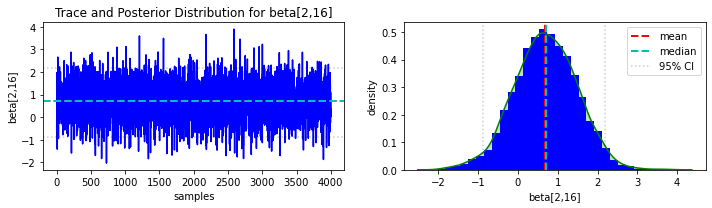

In [15]:
plt.rcParams["figure.figsize"]=(10,3)
pystan_utils.plot_trace(fit["alpha[1]"],"alpha[1]")
plt.show()
for d in range(1,D+1,3):
    c = np.random.choice(C+1)
    if c==0:
        c=1
    pystan_utils.plot_trace(fit["beta[%d,%d]"%(c,d)],"beta[%d,%d]"%(c,d))
    plt.show()
    

(4000, 4)
(4000, 4, 17)
(134, 17)
predictions: [2. 1. 4. 4. 4. 4. 4. 2. 4. 4. 4. 2. 2. 3. 1. 1. 1. 2. 4. 2. 1. 4. 4. 2.
 2. 4. 2. 4. 3. 2. 1. 3. 2. 4. 4. 4. 1. 2. 1. 4. 4. 1. 1. 2. 4. 4. 4. 1.
 1. 2. 2. 1. 2. 4. 3. 3. 4. 2. 3. 1. 2. 2. 1. 4. 4. 4. 4. 3. 4. 1. 4. 1.
 4. 2. 4. 2. 1. 4. 4. 3. 1. 3. 2. 1. 4. 2. 2. 4. 2. 2. 4. 1. 1. 2. 1. 4.
 4. 1. 2. 4. 1. 4. 4. 2. 4. 2. 2. 2. 1. 1. 3. 3. 4. 2. 2. 1. 1. 4. 4. 2.
 4. 4. 4. 2. 4. 3. 1. 2. 4. 2. 3. 2. 2. 4.]
true values: [2 1 3 4 4 4 1 2 4 2 4 2 2 3 1 1 1 2 4 2 1 4 1 2 2 4 4 4 3 2 1 4 2 4 4 4 4
 2 1 2 4 1 1 2 4 4 4 1 4 2 2 1 2 4 3 3 4 2 3 3 4 2 1 4 4 1 2 3 4 3 4 1 4 2
 4 2 4 2 4 3 1 4 2 3 4 4 2 4 2 2 4 1 1 4 4 4 4 3 2 2 4 1 4 4 4 2 2 2 1 3 3
 4 1 2 4 1 1 3 4 2 4 4 2 4 4 3 1 4 4 2 3 2 2 4]


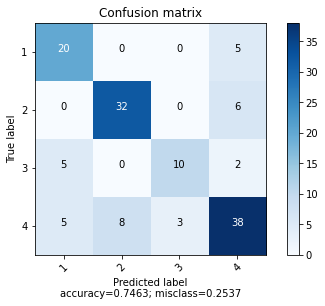

In [18]:
# make predictions for test set

alpha = fit["alpha"]
beta = fit["beta"]
print(alpha.shape)
print(beta.shape)
print(X_test.shape)

no_rw = int(iterations * no_chains /2)
no_cl = int(len(X_test))

Mat = np.zeros((no_rw,no_cl))
for i in range(no_rw):
    A = alpha[i].reshape(-1,1) + np.dot(beta[i],X_test.T)
    B = np.argmax(A, axis=0) + 1
    Mat[i,:] = B
    
from statistics import mode
# y_hat = [int(mode(Mat[:,i])) for i in range(len(X_test))] 
y_hat = np.zeros(len(X_test))
for i in range(len(X_test)):
    y_hat[i] = int(mode(Mat[:,i]))

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
# print("Accuracy:", np.sum(y_hat == y_test) / len(y_test))

pystan_utils.plot_confusion_matrix(confusion_matrix(y_test, y_hat),normalize= False, target_names=[1,2,3,4])

### ADVI method

In [11]:
%%time
# create Stan model object
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

Wall time: 18.5 s


In [12]:
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

predictions: [2 1 4 4 4 4 4 2 4 4 4 2 2 3 1 1 1 2 4 2 1 4 4 4 2 4 2 4 3 2 1 1 2 4 4 4 2
 2 1 4 4 1 1 4 4 4 4 1 4 2 2 1 2 4 3 3 4 2 3 1 2 2 1 4 4 4 4 3 4 1 4 1 4 2
 4 2 1 4 4 3 1 3 2 1 4 2 2 4 2 2 4 1 1 2 1 4 4 1 2 4 1 4 4 2 4 2 2 2 1 1 3
 3 4 2 2 1 1 4 4 2 4 4 4 2 4 3 1 2 4 2 3 2 2 4]
true values: [2 1 3 4 4 4 1 2 4 2 4 2 2 3 1 1 1 2 4 2 1 4 1 2 2 4 4 4 3 2 1 4 2 4 4 4 4
 2 1 2 4 1 1 2 4 4 4 1 4 2 2 1 2 4 3 3 4 2 3 3 4 2 1 4 4 1 2 3 4 3 4 1 4 2
 4 2 4 2 4 3 1 4 2 3 4 4 2 4 2 2 4 1 1 4 4 4 4 3 2 2 4 1 4 4 4 2 2 2 1 3 3
 4 1 2 4 1 1 3 4 2 4 4 2 4 4 3 1 4 4 2 3 2 2 4]


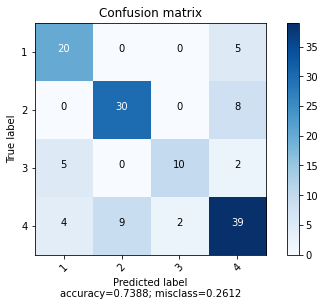

In [13]:
# make predictions for test set
y_hat = alpha.reshape(-1,1) + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
# print("Accuracy:", np.sum(y_hat == y_test) / len(y_test))

pystan_utils.plot_confusion_matrix(confusion_matrix(y_test, y_hat),normalize= False, target_names=[1,2,3,4])

### Non-Bayesian inference 

Just for the sake of comparision, lets run logistic regression from the popular sklearn package.

predictions: [2 1 4 4 4 4 4 2 4 4 4 2 2 3 1 1 1 2 4 2 1 4 4 2 2 4 2 4 3 2 1 3 2 4 4 4 1
 2 1 4 4 1 1 2 4 4 4 1 4 2 2 1 2 4 3 3 4 2 3 1 2 2 1 4 4 4 4 3 4 1 4 1 4 2
 4 2 1 4 4 3 1 3 2 1 4 2 2 4 2 2 4 1 1 2 1 4 4 1 2 4 1 4 4 2 4 2 2 2 1 1 3
 3 4 2 2 1 1 4 4 2 4 4 4 2 4 3 1 2 4 2 3 2 2 4]
true values: [2 1 3 4 4 4 1 2 4 2 4 2 2 3 1 1 1 2 4 2 1 4 1 2 2 4 4 4 3 2 1 4 2 4 4 4 4
 2 1 2 4 1 1 2 4 4 4 1 4 2 2 1 2 4 3 3 4 2 3 3 4 2 1 4 4 1 2 3 4 3 4 1 4 2
 4 2 4 2 4 3 1 4 2 3 4 4 2 4 2 2 4 1 1 4 4 4 4 3 2 2 4 1 4 4 4 2 2 2 1 3 3
 4 1 2 4 1 1 3 4 2 4 4 2 4 4 3 1 4 4 2 3 2 2 4]


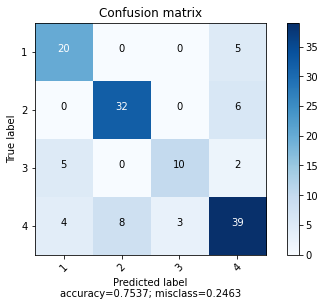

In [19]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
# print("Accuracy:", np.sum(y_hat == y_test) / len(y_test))
pystan_utils.plot_confusion_matrix(confusion_matrix(y_test, y_hat),normalize= False, target_names=[1,2,3,4])